Gradient descent
===
Gradient descent is a near-universal technique in numerical optimisation, underpinning large sections of the computer science/machine learning/astronomy literature.
This notebook aims to provide a high-level overview of the method, to help provide intuition and context for it's deployment in more complex situations.

In this notebook:
- What is gradient descent?
- Why 'normal' gradient descent for ML over other algorithms?
- Developing an intuition for the gradient descent algorithm: learning rate, dimensionality, where gradient descent goes wrong and how to fix it.
- Stochastic gradient descent - what do we do when our models/datasets get big or high-dimensional?
- Advanced patterns: adaptive flavours of gradient descent (Adam) and introducing momentum.

In [202]:
import jax
import pandas as pd

jax.config.update("jax_enable_x64", True)  # force JAX to use 64-bit mode
jnp = jax.numpy

import matplotlib.pyplot as plt
from scipy.optimize import minimize

Test functions
---
To test gradient descent and provide example functions to optimise, we define some example functions below.
These can be swapped in and out of the cells to follow depending on what you prefer.

More info:
Himmelblau's function: [Wikipedia](https://en.wikipedia.org/wiki/Himmelblau%27s_function)
Rosenbrock 'banana' function: [Wikipedia](https://en.wikipedia.org/wiki/Rosenbrock_function)

Number of function evaluations: 250000


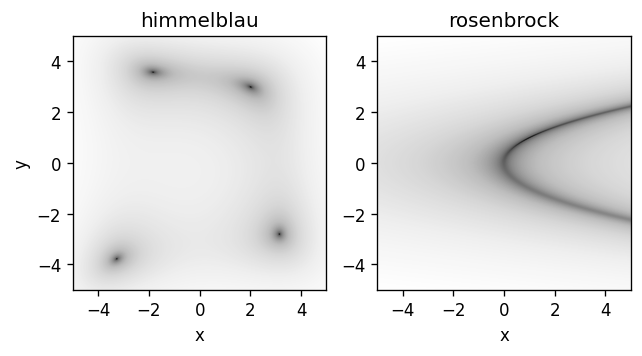

In [2]:
def himmelblau(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """
    Himmelblau test function for optimisation - has 4 global minima to find.
    """
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def rosenbrock(x: jnp.ndarray, y: jnp.ndarray, a=1, b=100) -> jnp.ndarray:
    """
    Rosenbrock banana function - one global minimum at (0, 0)
    """
    return (a - x)**2 + b*(y - x**2)**2

objective_funcs = [himmelblau, rosenbrock]

# here we define a plotting grid to visualise the test functions.
n_grid_points = 500
ygrid, xgrid = jnp.meshgrid(jnp.linspace(-5, 5, n_grid_points), jnp.linspace(-5, 5, n_grid_points))
print(f"Number of function evaluations: {n_grid_points * n_grid_points}")

fig, axes = plt.subplots(1, len(objective_funcs), sharey='col', dpi=120)

for ax, objfunc in zip(axes, objective_funcs):
    z_func = objfunc(xgrid, ygrid)
    ax.imshow(jnp.log10(z_func), origin='lower', extent=[-5, 5, -5, 5], cmap='Greys_r', interpolation='lanczos')
    ax.set_xlabel("x")
    ax.set_title(objfunc.__name__)

axes[0].set_ylabel("y")
plt.show()

Gradient descent
---
- This section is designed to give some intuition for gradient descent

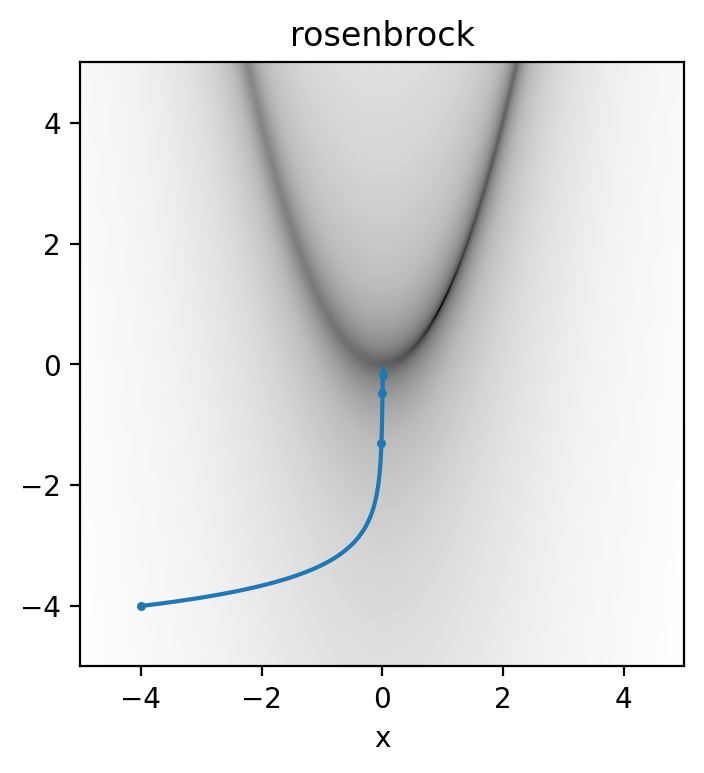

In [72]:
objfunc = rosenbrock
func_val_and_grad = jax.value_and_grad(objfunc, argnums=(0, 1))

init_loc = jnp.array([-4.0, -4.0])
eta = 1e-5
n_optim_steps = 2000

loss_values = jnp.zeros(n_optim_steps)
par_values = jnp.zeros((n_optim_steps, init_loc.shape[0]))

_pars = init_loc
for n in range(n_optim_steps):
    loss, grad = func_val_and_grad(*_pars)
    par_values = par_values.at[n, :].set(_pars)
    loss_values = loss_values.at[n].set(loss)
    _pars -= eta * jnp.array(grad)

fig, ax = plt.subplots(dpi=200)
z_func = objfunc(xgrid, ygrid)
ax.imshow(jnp.log10(z_func).T, origin='lower', extent=[-5, 5, -5, 5], cmap='Greys_r', interpolation='lanczos')
ax.set_xlabel("x")
ax.set_title(objfunc.__name__)

plt.plot(*par_values.T)
plt.scatter(*par_values[::500].T, s=5)
plt.show()

Stochastic gradient descent
---
- Now let's move to a more complex example. Let's fit a non-linear model to some outlier-filled data. At this point we can really see where SGD comes into it's own.
- Let's use a more complicated loss function - the [pseudo-Huber loss](https://en.wikipedia.org/wiki/Huber_loss). This smoothly interpolates between mean-squared error and the L1 loss.
- Let's also fit to real data: the light curve of a recent supernova SN2022hrs, as observed by the ASAS-SN survey.

In [152]:
@jax.jit
def bazin_function(pars, t):
    t0, trise, tfall, a, b = pars
    shape = jnp.exp((t0 - t)/tfall) / (1 + jnp.exp((t0 - t)/trise))
    return a * shape + b

@jax.jit
def huber_loss(y_obs, y_pred, yerr):
    norm_resid = (y_obs - y_pred) / yerr
    return jnp.sum(jnp.sqrt(1 + norm_resid**2) - 1)

In [170]:
data = pd.read_csv("../data/asas-sn_2022hrs.csv").sort_values("HJD").iloc[20:]

t_obs = data['HJD'].values
flux_obs = data['flux(mJy)'].values
flux_err_obs = data['flux_err'].values

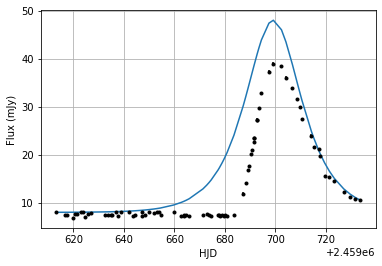

In [171]:
pars_guess = [t_obs[flux_obs.argmax()], 5.0, 10.0, 80.0, 8.0]

plt.errorbar(t_obs, flux_obs, yerr=flux_err_obs, fmt='.k')
plt.plot(t_obs, bazin_function(pars_guess, t_obs))
plt.xlabel("HJD")
plt.ylabel("Flux (mJy)")
plt.grid()
plt.show()

In [180]:
@jax.jit
def grad_step(pars, t, flux, ferr):
    model_pred = bazin_function(pars, t)
    loss_value = huber_loss(flux, model_pred, yerr=ferr)
    return loss_value

jac_grad = jax.jit(jax.jacfwd(grad_step, argnums=0))

In [211]:
n_optim_steps = 10000
eta = 5e-4

_pars = jnp.array(pars_guess)

parlist = jnp.zeros((n_optim_steps, _pars.shape[0]))
losslist = jnp.zeros(n_optim_steps)

for n in range(n_optim_steps):
    loss = grad_step(_pars, t_obs, flux_obs, flux_err_obs)
    grad = jnp.array(jac_grad(_pars, t_obs, flux_obs, flux_err_obs))
    losslist = losslist.at[n].set(loss)
    parlist = parlist.at[n, :].set(_pars)
    _pars -= eta*grad

    if not (n % 1000):
        print(f"step {n}:- loss: {loss:.3f} \ gradnorm: {jnp.linalg.norm(grad):.2f}")

print("###### optimisation finished ########")
print(f"step {n}:- loss: {loss:.3f} \ gradnorm: {jnp.linalg.norm(grad):.2f}")

step 0:- loss: 3926.182 \ gradnorm: 3021.95
step 1000:- loss: 551.546 \ gradnorm: 45.50
step 2000:- loss: 510.916 \ gradnorm: 7.46
step 3000:- loss: 488.832 \ gradnorm: 5.71
step 4000:- loss: 478.410 \ gradnorm: 2.90
step 5000:- loss: 476.006 \ gradnorm: 1.82
step 6000:- loss: 474.500 \ gradnorm: 1.69
step 7000:- loss: 473.098 \ gradnorm: 1.67
step 8000:- loss: 471.697 \ gradnorm: 1.68
step 9000:- loss: 470.291 \ gradnorm: 1.67
###### optimisation finished ########
step 9999:- loss: 468.976 \ gradnorm: 1.54


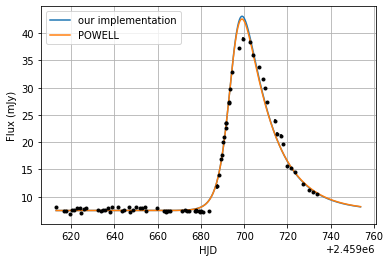

In [209]:
# let's now compare to FORTRAN-coded optimisers - note the far quicker runtime.
# this largely comes from adaptive step sizing

res = minimize(grad_step, x0=pars_guess, args=(t_obs, flux_obs, flux_err_obs), method='powell')

t_grid_range = jnp.linspace(t_obs.min(), t_obs.max() + 20, 1000)
plt.errorbar(t_obs, flux_obs, yerr=flux_err_obs, fmt='.k')
plt.plot(t_grid_range, bazin_function(_pars, t_grid_range), label='our implementation')
plt.plot(t_grid_range, bazin_function(res.x, t_grid_range), label='POWELL')
plt.xlabel("HJD")
plt.ylabel("Flux (mJy)")
plt.grid()
plt.legend()
plt.show()